#### Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

#### Load Data

In [2]:
input_file = 'farmer_survey_2026.csv'

df = pd.read_csv(input_file, parse_dates=['survey_date'])

print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded dataset: 1500 rows, 17 columns


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   farmer_id                1500 non-null   object        
 1   country                  1500 non-null   object        
 2   region                   1500 non-null   object        
 3   district                 1500 non-null   object        
 4   village                  1500 non-null   object        
 5   survey_date              1500 non-null   datetime64[ns]
 6   gps_latitude             1500 non-null   float64       
 7   gps_longitude            1500 non-null   float64       
 8   crop                     1500 non-null   object        
 9   farm_size_ha             1500 non-null   float64       
 10  yield_last_season_kg_ha  1331 non-null   float64       
 11  insured                  1500 non-null   object        
 12  premium_paid_usd         1500 non-

In [4]:
df.head(5)

,farmer_id,country,region,district,village,survey_date,gps_latitude,gps_longitude,crop,farm_size_ha,yield_last_season_kg_ha,insured,premium_paid_usd,claim_triggered,payout_amount_usd,field_agent_id,enumerator_notes
0,F-Zam-77258,Zambia,Central,Cen-Dist35,Vil-508,2024-07-27,-16.32,27.48,Sorghum,3.78,1657.00,No,0.00,No,0.00,ENUM034,NaN
1,F-Eth-32245,Ethiopia,Oromia,Oro-Dist12,Vil-917,2024-06-02,11.33,36.28,Wheat,4.84,1646.00,No,0.00,No,0.00,ENUM001,NaN
2,F-Eth-36922,Ethiopia,Oromia,Oro-Dist03,Vil-912,2023-02-24,12.49,39.25,Beans,4.66,NaN,Yes,26.02,No,0.00,ENUM039,NaN
3,F-Zam-18665,Zambia,Eastern,Eas-Dist19,Vil-267,2023-08-26,-11.20,25.33,Wheat,0.70,1714.00,Yes,13.61,No,0.00,ENUM022,NaN
4,F-Zam-83207,Zambia,Eastern,Eas-Dist13,Vil-186,2023-09-15,-13.90,31.72,Wheat,2.10,2060.00,No,0.00,No,0.00,ENUM002,NaN


#### Apply Quality Flags

In [5]:
# Initialize flag columns
df['flag_missing'] = 0
df['flag_duplicate'] = 0
df['flag_invalid_gps'] = 0
df['flag_yield_outlier'] = 0
df['flag_farm_size_outlier'] = 0
df['flag_illogical_insurance'] = 0
df['flag_illogical_claim'] = 0

# 1. Missing key fields (focus on critical: farmer_id, country, region, crop, insured)
key_cols = ['farmer_id', 'country', 'region', 'crop', 'insured']
df['flag_missing'] = df[key_cols].isnull().any(axis=1).astype(int)

# 2. Duplicates: mark all occurrences of duplicate farmer_id (except first)
df['flag_duplicate'] = df.duplicated(subset=['farmer_id'], keep=False).astype(int)

# 3. Invalid GPS: rough check - outside plausible East/Southern Africa bounds or extreme values
lat_ok = (df['gps_latitude'].between(-35, 20)) & (df['gps_latitude'].notnull())
lon_ok = (df['gps_longitude'].between(20, 50)) & (df['gps_longitude'].notnull())
df['flag_invalid_gps'] = (~(lat_ok & lon_ok)).astype(int)

# 4. Yield outliers: IQR method (common in survey QC)
yield_col = 'yield_last_season_kg_ha'
Q1 = df[yield_col].quantile(0.25)
Q3 = df[yield_col].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df['flag_yield_outlier'] = ((df[yield_col] < lower) | (df[yield_col] > upper)).astype(int)

# 5. Farm size outliers: unrealistic smallholder values (e.g., >10 ha or <0.1 ha flagged)
df['flag_farm_size_outlier'] = ((df['farm_size_ha'] < 0.1) | (df['farm_size_ha'] > 10)).astype(int)

# 6. Illogical insurance
df['flag_illogical_insurance'] = 0
df.loc[(df['insured'] == 'Yes') & (df['premium_paid_usd'] <= 0), 'flag_illogical_insurance'] = 1
df.loc[(df['insured'] == 'No') & (df['premium_paid_usd'] > 0), 'flag_illogical_insurance'] = 1

# 7. Illogical claim
df['flag_illogical_claim'] = 0
df.loc[(df['claim_triggered'] == 'Yes') & (df['payout_amount_usd'] <= 0), 'flag_illogical_claim'] = 1
df.loc[(df['claim_triggered'] == 'No') & (df['payout_amount_usd'] > 0), 'flag_illogical_claim'] = 1

# Total issues per row
flag_cols = [col for col in df.columns if col.startswith('flag_')]
df['total_issues'] = df[flag_cols].sum(axis=1)

print("Quality flags added. Summary of issues:")
df[flag_cols + ['total_issues']].sum()

Quality flags added. Summary of issues:


flag_missing                  0
flag_duplicate              151
flag_invalid_gps             27
flag_yield_outlier           46
flag_farm_size_outlier        0
flag_illogical_insurance      0
flag_illogical_claim         21
total_issues                245
dtype: int64

#### Quality Summary KPIs

##### Overall quality score: % rows with 0 issues

In [6]:
overall_clean_pct = (df['total_issues'] == 0).mean() * 100
print(f"Overall clean records: {overall_clean_pct:.1f}%")

Overall clean records: 84.5%


##### Quality by country

In [7]:
quality_by_country = df.groupby('country').agg(
    total_records=('farmer_id', 'count'),
    clean_records=('total_issues', lambda x: (x==0).sum()),
    avg_issues=('total_issues', 'mean'),
    pct_clean=('total_issues', lambda x: (x==0).mean()*100)
).round(2)
print("\nQuality by Country:")
display(quality_by_country)


Quality by Country:


,total_records,clean_records,avg_issues,pct_clean
country,,,,
Ethiopia,748,634,0.16,84.76
Kenya,457,384,0.17,84.03
Zambia,295,250,0.17,84.75


##### Quality by region (top issues)

In [8]:
quality_by_region = df.groupby('region')['total_issues'].agg(['count', 'mean', lambda x: (x==0).mean()*100]).round(2)
quality_by_region.columns = ['records', 'avg_issues', 'pct_clean']
print("\nQuality by Region:")
display(quality_by_region)


Quality by Region:


,records,avg_issues,pct_clean
region,,,
Amhara,355,0.16,84.23
Central,248,0.11,88.71
Eastern,100,0.25,77.00
Oromia,393,0.16,85.24
Rift Valley,162,0.21,81.48
Southern,93,0.15,87.10
Western,149,0.17,83.22


##### Top agents with issues

In [9]:
agent_quality = df.groupby('field_agent_id')['total_issues'].agg(['count', 'mean']).sort_values('mean', ascending=False).head(10)
print("\nAgents with highest avg issues:")
display(agent_quality)


Agents with highest avg issues:


,count,mean
field_agent_id,,
ENUM036,26,0.31
ENUM028,35,0.29
ENUM032,29,0.28
ENUM011,29,0.28
ENUM009,37,0.27
ENUM001,31,0.26
ENUM035,40,0.25
ENUM014,24,0.25
ENUM007,33,0.24


##### Visualize missing + issues

C:\Users\Eldu\AppData\Local\Temp\ipykernel_10928\1394385273.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='total_issues', data=df, palette='viridis')


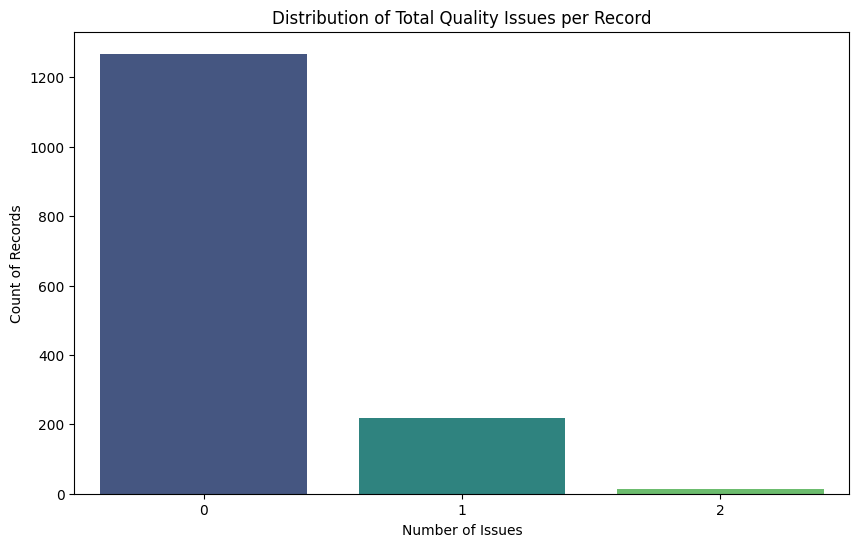

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='total_issues', data=df, palette='viridis')
plt.title('Distribution of Total Quality Issues per Record')
plt.xlabel('Number of Issues')
plt.ylabel('Count of Records')
plt.show()

#### Create Cleaned Dataset

In [11]:
clean_df = df.copy()

# Drop exact duplicates
clean_df = clean_df.drop_duplicates(subset=['farmer_id'], keep='first')

# For numerics: impute missing yields with median per crop (simple imputation demo)
median_yield_by_crop = clean_df.groupby('crop')['yield_last_season_kg_ha'].median()
clean_df['yield_last_season_kg_ha'] = clean_df.apply(
    lambda row: median_yield_by_crop[row['crop']] if pd.isna(row['yield_last_season_kg_ha']) else row['yield_last_season_kg_ha'],
    axis=1
)

clean_df.to_csv('farmer_survey_cleaned_2026.csv', index=False)
print(f"Cleaned dataset saved: {clean_df.shape[0]} rows")

Cleaned dataset saved: 1421 rows
